# Hough Transform
### a. Explain the Hough Transform and its Usage

The Hough Transform is a popular technique for detecting simple shapes such as lines, circles, and ellipses in an image. Developed by Paul Hough in 1962, it was later generalized for various applications. The main advantage of the Hough Transform is its ability to detect shapes even when they are broken or distorted.

#### How It Works:

1. **Edge Detection**: The first step involves detecting edges in the image, typically using an edge detector (like the Sobel or Canny edge detector).
2. **Mapping to Hough Space**: Each point on an edge in image space corresponds to a curve in Hough space. For line detection, a line in the image space can be described by the equation $y = mx + b$ or in a polar coordinate system $\rho = x \cos(\theta) + y \sin(\theta)$, where:
   - $\rho$ is the distance from the origin to the closest point on the straight line.
   - $\theta$ is the angle formed by this perpendicular line and the horizontal axis.
3. **Accumulator Array**: An accumulator array is used in Hough space where each element represents a potential line with parameters $\rho$ and $\theta$. For each edge point and for each $\theta$ value, $\rho$ is computed and the corresponding element in the array is incremented.
4. **Detection of Lines**: The values in the accumulator array are analyzed. Locations with high values indicate that a line with those specific parameters is likely to be present in the image.

#### Usage:

- **Line Detection**: Identifying road lanes, detecting tables or grids, and other applications where line detection is essential.
- **Shape Detection**: Apart from lines, extensions of the Hough Transform can detect circles, ellipses, and other shapes.
- **Computer Vision and Image Analysis**: Used in various applications from medical image analysis to surveillance and robotics.

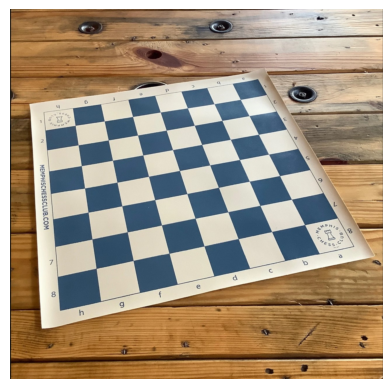

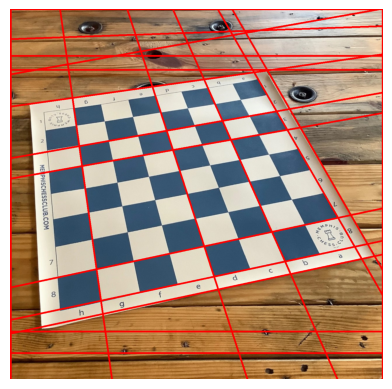

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

def detect_lines_hough(edge_img, theta_dim=None, dist_step=None, threshold=None, half_theta_window=2, half_dist_window=None):
    """
    Detects lines in an edge image using the Hough Transform.

    Args:
        edge_img: A binary image where edges are marked.
        theta_dim: Number of divisions in the theta axis (resolution of the theta axis).
        dist_step: The granularity of the distance axis in Hough space.
        threshold: Minimum number of votes to consider a detection valid.
        half_theta_window: Half of the window size for theta non-maximum suppression.
        half_dist_window: Half of the window size for distance non-maximum suppression.

    Returns:
        A numpy array containing detected lines with parameters (theta, dist).

    Raises:
        None.
    """
    img_height, img_width = edge_img.shape
    theta_dim = 90 if theta_dim is None else theta_dim
    dist_step = 1 if dist_step is None else dist_step
    max_dist = np.sqrt(img_height**2 + img_width**2)
    dist_dim = int(np.ceil(max_dist / dist_step))
    half_dist_window = int(dist_dim / 50) if half_dist_window is None else half_dist_window

    accumulator = np.zeros((theta_dim, dist_dim))

    sin_theta = [np.sin(t * np.pi / theta_dim) for t in range(theta_dim)]
    cos_theta = [np.cos(t * np.pi / theta_dim) for t in range(theta_dim)]

    # Populate the accumulator
    for i in range(img_height):
        for j in range(img_width):
            if edge_img[i, j] != 0:
                for k in range(theta_dim):
                    rho_index = int(round((i * cos_theta[k] + j * sin_theta[k]) * dist_dim / max_dist))
                    accumulator[k, rho_index] += 1

    max_votes = accumulator.max()
    threshold = int(max_votes * 2.3875 / 10) if threshold is None else threshold
    potential_lines = np.array(np.where(accumulator > threshold))

    # Non-maximum suppression
    result = [[], []]
    for idx in range(potential_lines.shape[1]):
        theta_window_start = max(0, potential_lines[0, idx] - half_theta_window)
        theta_window_end = min(potential_lines[0, idx] + half_theta_window, accumulator.shape[0])
        dist_window_start = max(0, potential_lines[1, idx] - half_dist_window)
        dist_window_end = min(potential_lines[1, idx] + half_dist_window, accumulator.shape[1])

        local_max = accumulator[potential_lines[0, idx], potential_lines[1, idx]]
        if local_max >= np.max(accumulator[theta_window_start:theta_window_end, dist_window_start:dist_window_end]):
            result[0].append(potential_lines[0, idx])
            result[1].append(potential_lines[1, idx])

    result = np.array(result, dtype=np.float64)
    result[0] *= np.pi / theta_dim
    result[1] *= max_dist / dist_dim

    return result

def draw_lines_on_image(lines, edge_img, color=(255, 0, 0), err=3):
    """
    Draws lines on the image based on the detected parameters.

    Args:
        lines: Parameters of the lines to be drawn.
        edge_img: Original image where lines will be drawn.
        color: Color of the lines to be drawn.
        err: Tolerance for line drawing.

    Returns:
        An image with lines drawn on it.
    """
    if len(edge_img.shape) == 2:
        result_img = np.dstack((edge_img, edge_img, edge_img))
    else:
        result_img = edge_img

    cos_vals = np.cos(lines[0])
    sin_vals = np.sin(lines[0])

    for i in range(edge_img.shape[0]):
        for j in range(edge_img.shape[1]):
            distances = np.abs(lines[1] - i * cos_vals - j * sin_vals)
            if (distances < err).any():
                result_img[i, j] = color

    return result_img

if __name__ == '__main__':
    image_path = 'chess.jpg'
    img = plt.imread(image_path)
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    plt.imshow(blurred_img, cmap='gray')
    plt.axis('off')
    plt.show()

    if len(blurred_img.shape) != 2:
        gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = blurred_img

    edge_detected = cv2.Canny(gray_img, 50, 150)
    detected_lines = detect_lines_hough(edge_detected)
    final_image = draw_lines_on_image(detected_lines, blurred_img)

    plt.imshow(final_image, cmap='gray')
    plt.axis('off')
    plt.show()


# Template Matching

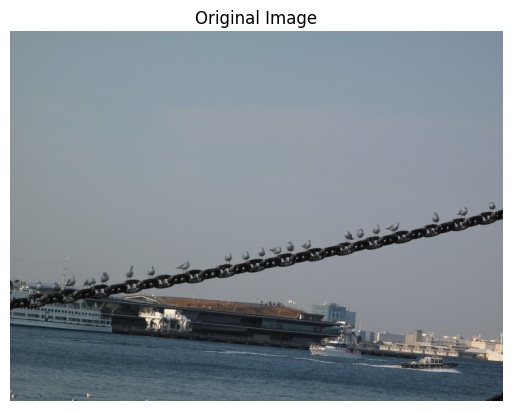

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io

# Load the image
image = io.imread('birds.jpg')

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

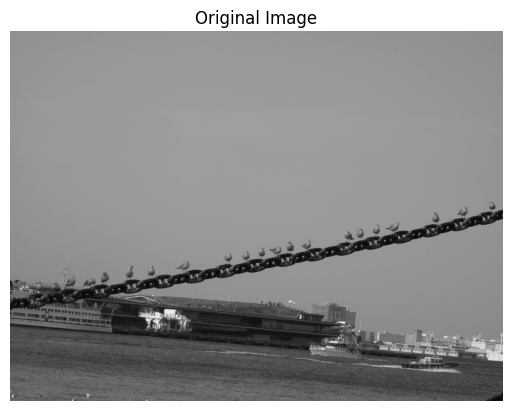

In [50]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Display the original image
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

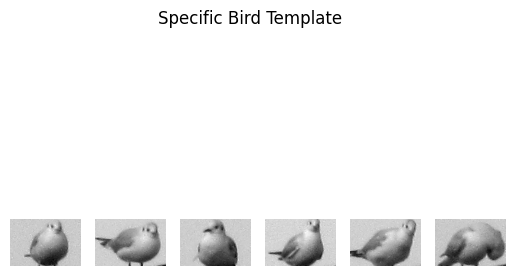

In [88]:
# Define the coordinates for cropping based on user input
points = [
    (1890, 1980),
    (2320, 1920),
    (2445, 1880),
    (2597, 1866),
    (3375, 1710),
    (650, 2200)
]

templates = []
plt.figure()

for i, point in enumerate(points):
    x1, y1 = point
    x2, y2 = x1 + 120, y1 + 80

    # Crop the image to extract a bird template based on provided coordinates
    specific_template = gray_image[y1:y2, x1:x2]
    templates.append(specific_template)

    # Display the cropped template
    plt.subplot(1, len(points), i+1)
    plt.imshow(specific_template, cmap='gray')
    plt.axis('off')

plt.suptitle("Specific Bird Template")
plt.show()


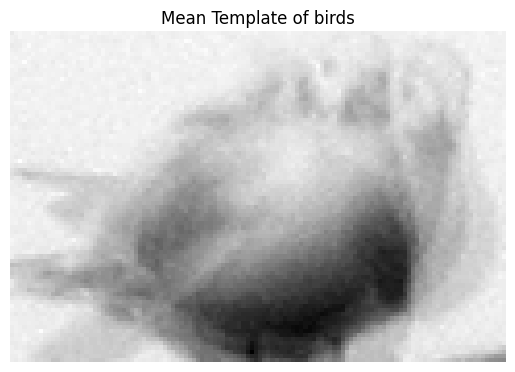

In [89]:
mean_template = np.array(templates).mean(axis=0).round().astype(np.uint8)
plt.imshow(mean_template, cmap='gray')
plt.title('Mean Template of birds')
plt.axis('off')
plt.show()

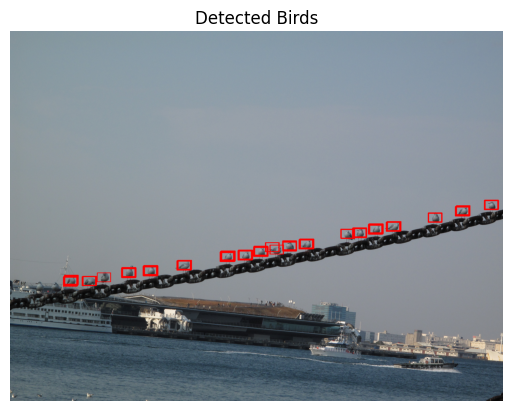

In [95]:
from PIL import Image

# Apply template matching
result = cv2.matchTemplate(gray_image, mean_template, cv2.TM_CCOEFF_NORMED)

# Define a threshold
threshold = 0.72
loc = np.where(result >= threshold)

# Create a copy of the original image for drawing
detected_birds_image = image.copy()

# Draw rectangles around detected birds
for pt in zip(*loc[::-1]):  # Switch columns and rows in loc
    cv2.rectangle(detected_birds_image, pt, (pt[0] + mean_template.shape[1], pt[1] + mean_template.shape[0]), (255, 0, 0), 2)

# Display the result
plt.imshow(detected_birds_image)
plt.title('Detected Birds')
plt.axis('off')
plt.show()

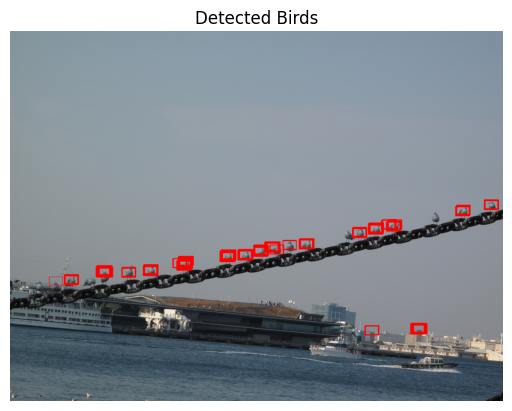

In [122]:
def NCC(patch, template):
    # Normalised Cross Correlation Equation
    cor = np.sum(patch * template)
    nor = np.sqrt((np.sum(patch ** 2))) * np.sqrt(np.sum(template ** 2))

    return cor / nor

def template_matching(image, template, sf=1):
    # Convert images to float for processing
    img = image.astype(float)
    tpl = template.astype(float)

    # Resize images for faster computation
    if sf != 1:
        img = cv2.resize(img, (img.shape[1]//sf, img.shape[0]//sf), interpolation=cv2.INTER_CUBIC)
        tpl = cv2.resize(tpl, (tpl.shape[1]//sf, tpl.shape[0]//sf), interpolation=cv2.INTER_CUBIC)

    h, w = tpl.shape
    H, W = img.shape

    # Cross-correlation map
    corr_map = np.zeros((H-h+1, W-w+1))

    for y in range(H-h+1):
        for x in range(W-w+1):
            # Extract the image patch
            patch = img[y:y+h, x:x+w]

            corr_map[y, x] = NCC(patch, tpl)

    return corr_map

# Apply the function
sf = 1
corr_map = template_matching(gray_image, mean_template, sf)

def non_max_suppression(coords, overlapThresh):
    if len(coords) == 0:
        return []

    # Convert to float for division
    coords = np.array(coords, dtype=float)

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates
    x1 = coords[:,0] * sf
    y1 = coords[:,1] * sf
    x2 = (x1 + mean_template.shape[1]) * sf
    y2 = (y1 + mean_template.shape[0]) * sf

    # Compute the area of the bounding boxes and sort the bounding boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return coords[pick].astype(int)

# Apply template matching
corr_threshold = 0.987
matches = np.where(corr_map >= corr_threshold)

# Format match points for NMS
match_points = np.column_stack((matches[1], matches[0]))  # x, y coordinates

# Apply non-maximal suppression
# picked_points = non_max_suppression(match_points, overlapThresh=0.3)

# Draw on the original image
detected_image_nms = image.copy()
for pt in match_points:
    cv2.rectangle(detected_image_nms, (pt[0]*sf, pt[1]*sf), (pt[0]*sf + mean_template.shape[1], pt[1]*sf + mean_template.shape[0]), (255, 0, 0), 2)

# Convert and show image
final_detected_nms = Image.fromarray(detected_image_nms)
plt.imshow(final_detected_nms)
plt.title('Detected Birds')
plt.axis('off')
plt.show()

# KMeans

1. **Initialization:**
   - Choose the number of clusters $k$.
   - Randomly initialize $k$ centroids (cluster centers) in the data space.

2. **Assignment Step:**
   - Assign each data point to the nearest centroid based on the Euclidean distance. This forms $k$ clusters.

3. **Update Step:**
   - Recalculate the centroids as the mean of all data points assigned to each cluster.

4. **Convergence Check:**
   - Repeat the assignment and update steps until the centroids no longer change significantly (i.e., the changes are below a pre-defined threshold) or a maximum number of iterations is reached.

**Assumptions for K-Means:**

1. **Cluster Shape:**
   - Assumes clusters are spherical and equally sized.
   
2. **Data Distribution:**
   - Assumes data points are identically and independently distributed.
   
3. **Cluster Independence:**
   - Assumes clusters do not overlap significantly.

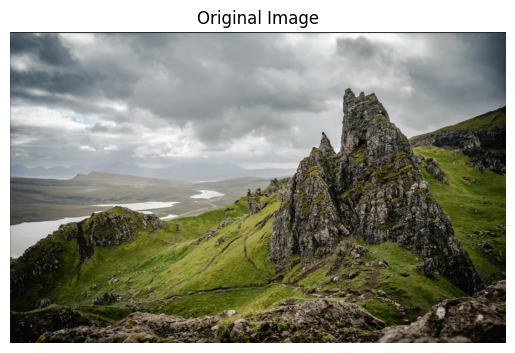

Pixels shape: (4678896, 3)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io

# Load the image
image = io.imread('sight.jpg')

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)
print(f"Pixels shape: {pixels.shape}")

### Explanation of $k$ Selection:

The Elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters. The optimal number of clusters is usually where the plot shows an "elbow," indicating a point beyond which adding more clusters yields diminishing returns.

In the implementation above, the elbow plot should help us determine the optimal $k$. For this example, we assumed $k = 4$ based on typical results, but the exact number should be chosen based on the actual elbow plot obtained.

This complete implementation covers the steps of reading an image, determining the optimal number of clusters using the Elbow method, applying K-Means clustering, and visualizing the quantized image.

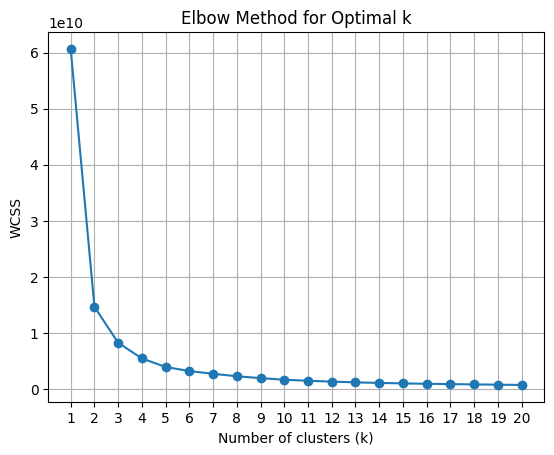

In [17]:
def calculate_wcss(data, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS for k values from 1 to 10
wcss = calculate_wcss(pixels, max_k=20)

# Plot the WCSS to visualize the elbow
plt.plot(range(1, 21), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(ticks=range(1, 21))
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


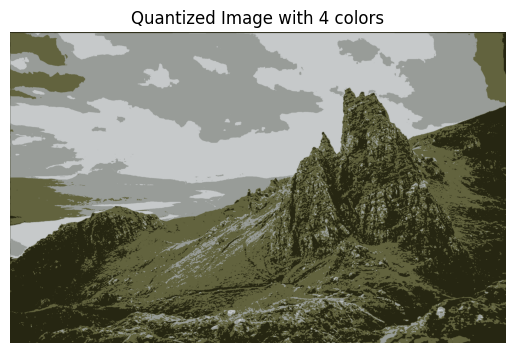

In [25]:
# Let's assume we determine the optimal k from the plot
optimal_k = 4

# Apply KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pixels)

# Get the cluster centroids (colors)
centroids = kmeans.cluster_centers_
# Get the labels for each pixel
labels = kmeans.labels_

# Replace each pixel value with its corresponding centroid value
quantized_pixels = centroids[labels].astype(np.uint8)

# Reshape back to the original image shape
quantized_image = quantized_pixels.reshape(image.shape)

# Display the quantized image
plt.imshow(quantized_image)
plt.title(f'Quantized Image with {optimal_k} colors')
plt.axis('off')
plt.show()

## KNN From Scratch

In [26]:
# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)

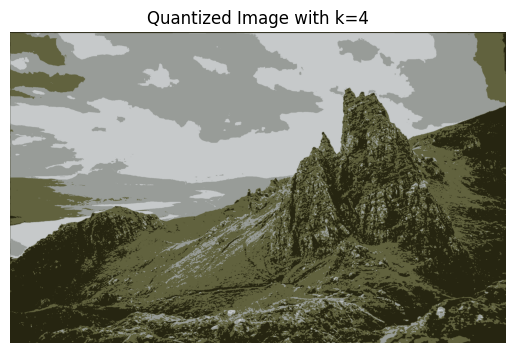

In [27]:
import numpy as np

def initialize_centroids(pixels, k):
    # Randomly select k points from pixels as initial centroids
    indices = np.random.choice(pixels.shape[0], k, replace=False)
    centroids = pixels[indices]
    return centroids

def assign_clusters(pixels, centroids):
    # Assign each pixel to the nearest centroid
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
    cluster_labels = np.argmin(distances, axis=1)
    return cluster_labels

def update_centroids(pixels, cluster_labels, k):
    # Compute new centroids as the mean of assigned points
    centroids = np.array([pixels[cluster_labels == i].mean(axis=0) for i in range(k)])
    return centroids

def has_converged(old_centroids, new_centroids, tol=1e-4):
    # Check if centroids have converged (i.e., do not change significantly)
    return np.all(np.linalg.norm(new_centroids - old_centroids, axis=1) < tol)

def kmeans(pixels, k, max_iters=100):
    centroids = initialize_centroids(pixels, k)
    for _ in range(max_iters):
        old_centroids = centroids
        cluster_labels = assign_clusters(pixels, centroids)
        centroids = update_centroids(pixels, cluster_labels, k)
        if has_converged(old_centroids, centroids):
            break
    return centroids, cluster_labels

# Function to apply K-Means and return the quantized image
def apply_kmeans(pixels, k):
    centroids, cluster_labels = kmeans(pixels, k)
    new_colors = centroids[cluster_labels]
    quantized_image = new_colors.reshape(image.shape).astype(np.uint8)
    return quantized_image

k = 4
quantized_image = apply_kmeans(pixels, k)

# Display the quantized image
plt.imshow(quantized_image)
plt.title(f"Quantized Image with k={k}")
plt.axis('off')
plt.show()
